# Critical Transitions in Traffic: **Actual vs Simulated vs CA (NaSch) vs Bando/OVM**

This notebook compares **critical points** across four views:
1. **Actual (LTA Speed Bands → OSM edges)**
2. **Mesoscopic Scenario (demand & rain)**
3. **Cellular Automaton (NaSch)**
4. **Bando / Optimal Velocity Model (OVM)**

We compute fundamental diagrams (FDs) and estimate **breakpoints** using a simple piecewise-linear estimator and a variance-peak proxy.


## 0) Environment & Keys

Set `LTA_ACCOUNT_KEY` or paste in the cell. NEA rainfall is optional here.


In [1]:
import os, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

LTA_ACCOUNT_KEY = os.getenv('LTA_ACCOUNT_KEY', '99v+LNo8S4qid/MgSTDrkA==')


## 1) Breakpoint and susceptibility helpers

In [2]:
from dataclasses import dataclass

@dataclass
class BreakpointResult:
    x_star: float
    i_star: int
    slopes: tuple
    intercepts: tuple
    sse: float

def estimate_breakpoint(x, y, min_frac=0.15):
    x = np.asarray(x); y = np.asarray(y)
    n = len(x)
    kmin = max(2, int(min_frac*n))
    kmax = min(n-2, n - kmin)
    best = None
    for k in range(kmin, kmax+1):
        x1, y1 = x[:k], y[:k]
        x2, y2 = x[k:], y[k:]
        A1 = np.vstack([np.ones_like(x1), x1]).T
        A2 = np.vstack([np.ones_like(x2), x2]).T
        try:
            b1, b2 = np.linalg.lstsq(A1, y1, rcond=None)[0][1], np.linalg.lstsq(A1, y1, rcond=None)[0][0]
            c1, c2 = np.linalg.lstsq(A2, y2, rcond=None)[0][1], np.linalg.lstsq(A2, y2, rcond=None)[0][0]
        except Exception:
            continue
        y1hat = b2 + b1*x1
        y2hat = c2 + c1*x2
        sse = ((y1 - y1hat)**2).sum() + ((y2 - y2hat)**2).sum()
        if (best is None) or (sse < best.sse):
            best = BreakpointResult(x_star=float(x[k]), i_star=k,
                                    slopes=(float(b1), float(c1)),
                                    intercepts=(float(b2), float(c2)),
                                    sse=float(sse))
    return best

def susceptibility_peak(x, y, window=3):
    x = np.asarray(x); y = np.asarray(y)
    varv = []
    for i in range(len(y)):
        lo = max(0, i-window); hi = min(len(y), i+window+1)
        varv.append(np.var(y[lo:hi], ddof=1) if hi-lo>2 else 0.0)
    varv = np.asarray(varv)
    i_star = int(np.nanargmax(varv)) if len(varv) else 0
    return float(x[i_star]) if len(x) else np.nan, float(varv[i_star]) if len(varv) else np.nan, varv


## 2) Actual network (OSMnx + LTA TSB) → Observed FD proxy

In [3]:
RUN_LIVE_LTA = True

import requests, geopandas as gpd, osmnx as ox, networkx as nx
from shapely.geometry import LineString

def fetch_all_lta(url, headers):
    out, next_url = [], url
    while next_url:
        r = requests.get(next_url, headers=headers, timeout=30)
        r.raise_for_status()
        j = r.json()
        out.extend(j.get('value', []))
        next_url = j.get('@odata.nextLink') or j.get('odata.nextLink')
    return pd.json_normalize(out)

if RUN_LIVE_LTA:
    assert LTA_ACCOUNT_KEY and LTA_ACCOUNT_KEY!='<PUT_YOUR_LTA_ACCOUNT_KEY_HERE>', 'Set LTA_ACCOUNT_KEY.'
    headers = {'AccountKey': LTA_ACCOUNT_KEY}
    URL_TSB = 'https://datamall2.mytransport.sg/ltaodataservice/v4/TrafficSpeedBands'
    tsb = fetch_all_lta(URL_TSB, headers)
    if {'MinimumSpeed','MaximumSpeed'}.issubset(tsb.columns):
        tsb['speed_kph_obs'] = (tsb['MinimumSpeed'].astype(float)+tsb['MaximumSpeed'].astype(float))/2
    else:
        band_mid = {1:5,2:15,3:25,4:35,5:45,6:55,7:65,8:75}
        tsb['speed_kph_obs'] = tsb['SpeedBand'].map(band_mid)
else:
    tsb = pd.DataFrame(columns=['StartLon','StartLat','EndLon','EndLat','speed_kph_obs'])

ox.settings.use_cache = True
G = ox.graph_from_place('Singapore', network_type='drive')
#G = ox.simplify_graph(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges_gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
if not {'u','v','key'}.issubset(edges_gdf.columns):
    edges_gdf = edges_gdf.reset_index()
edge_cols = [c for c in ['u','v','key','geometry','length','highway','speed_kph'] if c in edges_gdf.columns]
edges = edges_gdf[edge_cols].copy().set_crs(4326)

if RUN_LIVE_LTA and len(tsb):
    for c in ['StartLon','StartLat','EndLon','EndLat']:
        tsb[c] = pd.to_numeric(tsb[c], errors='coerce')
    tsb = tsb.dropna(subset=['StartLon','StartLat','EndLon','EndLat']).copy()
    tsb['geometry'] = tsb.apply(lambda r: LineString([(r['StartLon'], r['StartLat']),
                                                      (r['EndLon'],   r['EndLat'])]), axis=1)
    tsb_g = gpd.GeoDataFrame(tsb, geometry='geometry', crs='EPSG:4326')

    edges_3414 = edges.to_crs(3414)
    tsb_buf = tsb_g.to_crs(3414).copy(); tsb_buf['geometry'] = tsb_buf.geometry.buffer(25)
    hit = gpd.sjoin(edges_3414, tsb_buf[['geometry','speed_kph_obs']], how='inner', predicate='intersects')
    edge_speed = hit.groupby(['u','v','key'], as_index=False)['speed_kph_obs'].mean()
    edges_obs = edges_3414.merge(edge_speed, on=['u','v','key'], how='left').to_crs(4326)
    edges_obs['chi'] = edges_obs['speed_kph_obs'] / edges_obs['speed_kph']
    edges_obs['rho_hat'] = (1 - edges_obs['chi']).clip(0, 1)
    observed = edges_obs.dropna(subset=['rho_hat','chi']).copy()
else:
    observed = pd.DataFrame(columns=['rho_hat','chi'])

print('Observed edges:', len(observed))


Observed edges: 257


In [10]:
observed

,u,v,key,geometry,length,highway,speed_kph,speed_kph_obs,chi,rho_hat
103,74389911,4594223605,0,"LINESTRING (103.83737 1.29557, 103.8373 1.29567)",14.449267,tertiary,50.0,26.500000,0.530000,0.470000
104,74389911,4594223372,0,"LINESTRING (103.83737 1.29557, 103.83721 1.295...",93.224668,primary,50.0,28.785714,0.575714,0.424286
105,74389915,4594223598,0,"LINESTRING (103.8405 1.29588, 103.84051 1.29596)",8.500714,residential,50.0,30.214286,0.604286,0.395714
106,74389915,682933119,0,"LINESTRING (103.8405 1.29588, 103.84033 1.2958...",191.996313,primary,50.0,26.166667,0.523333,0.476667
107,74392496,6232047026,0,"LINESTRING (103.84213 1.29407, 103.84206 1.29417)",12.923467,primary,50.0,27.000000,0.540000,0.460000
...,...,...,...,...,...,...,...,...,...,...
44352,258305510,258305511,0,"LINESTRING (103.90145 1.30748, 103.9017 1.3071...",160.824252,residential,50.0,4.500000,0.090000,0.910000
44353,258305510,258305453,0,"LINESTRING (103.90145 1.30748, 103.90137 1.307...",72.578463,residential,50.0,4.500000,0.090000,0.910000
44354,258305510,258305494,0,"LINESTRING (103.90145 1.30748, 103.90147 1.307...",68.077366,residential,50.0,4.500000,0.090000,0.910000
44554,259401348,258304508,0,"LINESTRING (103.90759 1.30488, 103.90723 1.305...",255.979415,residential,50.0,14.500000,0.290000,0.710000


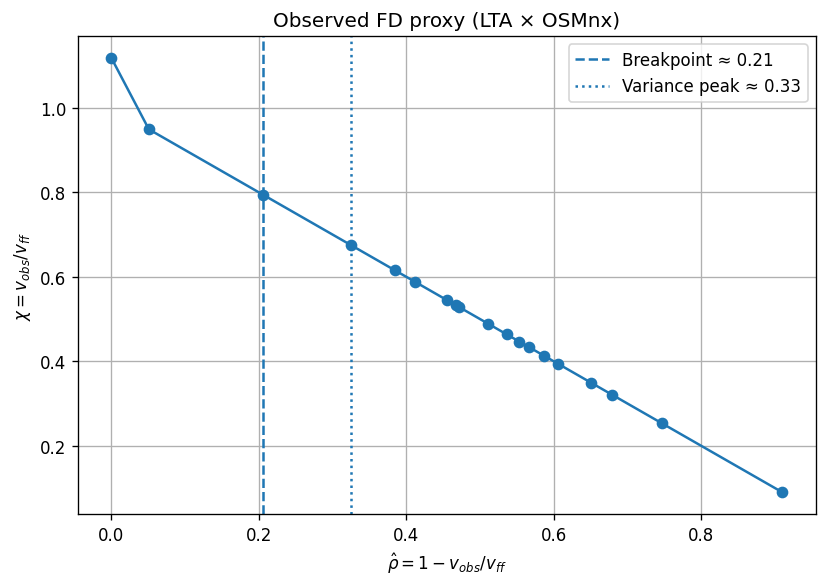

In [4]:
def bin_xy(x, y, bins=20):
    x = np.asarray(x); y = np.asarray(y)
    ok = ~np.isnan(x) & ~np.isnan(y)
    x = x[ok]; y = y[ok]
    if len(x)==0: return np.array([]), np.array([]), np.array([])
    qs = np.quantile(x, np.linspace(0,1,bins+1))
    xc = []; yc = []; yv = []
    for i in range(bins):
        mask = (x>=qs[i]) & (x<=qs[i+1] if i==bins-1 else x<qs[i+1])
        if mask.sum()>=5:
            xc.append(x[mask].mean()); yc.append(y[mask].mean()); yv.append(y[mask].var(ddof=1))
    return np.array(xc), np.array(yc), np.array(yv)

if len(observed):
    x_obs, y_obs, v_obs = bin_xy(observed['rho_hat'].values, observed['chi'].values, bins=24)
    bp_obs = estimate_breakpoint(x_obs, y_obs) if len(x_obs)>6 else None
    xsus, susmax, sus_series = susceptibility_peak(x_obs, y_obs) if len(x_obs)>6 else (np.nan, np.nan, None)

    plt.figure(); plt.plot(x_obs, y_obs, 'o-');
    if bp_obs: plt.axvline(bp_obs.x_star, linestyle='--', label=f'Breakpoint ≈ {bp_obs.x_star:.2f}')
    if not np.isnan(xsus): plt.axvline(xsus, linestyle=':', label=f'Variance peak ≈ {xsus:.2f}')
    plt.xlabel(r'$\hat{\rho}=1-v_{obs}/v_{ff}$'); plt.ylabel(r'$\chi=v_{obs}/v_{ff}$');
    plt.title('Observed FD proxy (LTA × OSMnx)'); plt.legend(); plt.tight_layout(); plt.show()
else:
    print('No observed data available (skipped plot).')


## 3) Scenario FD (demand sweep)

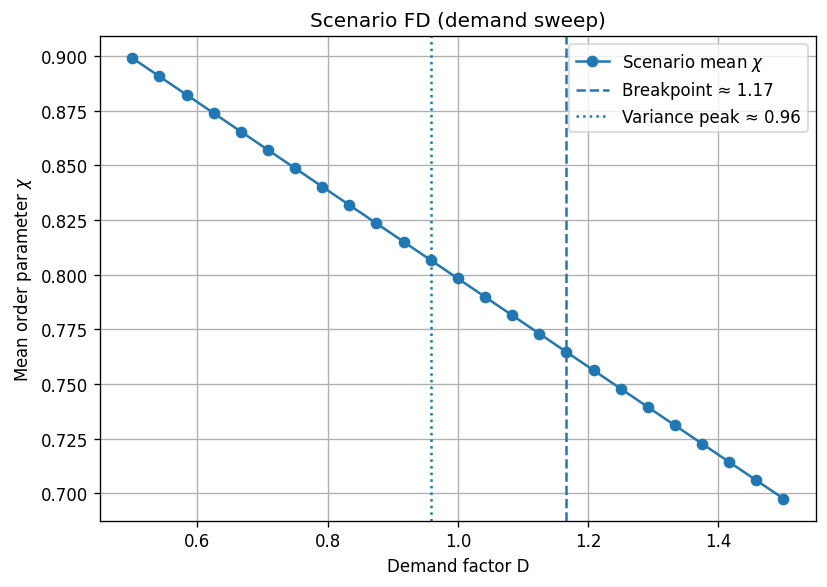

In [6]:
# --- Utilities to sanitize road classes and speeds ---
import pandas as pd
import numpy as np

def _normalize_road_cat_col(df, src_col="highway", out_col="road_cat"):
    """Make a single string road category from possibly list/dict/NaN 'highway'."""
    def norm(x):
        if isinstance(x, (list, tuple, set)):
            # prefer first string label
            for e in x:
                if isinstance(e, str) and e:
                    return e
            # fallback: stringify first element
            try:
                return str(next(iter(x)))
            except StopIteration:
                return "other"
        if isinstance(x, dict):
            # e.g. {'highway': 'primary'}; take first value
            try:
                return str(next(iter(x.values())))
            except StopIteration:
                return "other"
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return "other"
        return str(x)
    df[out_col] = df[src_col].apply(norm) if src_col in df.columns else "other"
    return df

def _ensure_numeric_speed(df, col="speed_kph"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def simple_fd_params_from_observed(df):
    """
    Build per-road-class FD params from a snapshot DataFrame/GeoDataFrame.
    Handles list-valued 'highway' by normalizing to a string category.
    """
    if df is None or len(df) == 0:
        return {'default': {'vf_med': 60.0, 'kj_scale': 1.0}}, pd.DataFrame()

    df = df.copy()
    df = _ensure_numeric_speed(df, "speed_kph")
    df = _normalize_road_cat_col(df, src_col="highway", out_col="road_cat")

    # guard against missing/zero speeds
    base = df.loc[df["speed_kph"].fillna(0) > 0, ["road_cat", "speed_kph"]].copy()
    if base.empty:
        return {'default': {'vf_med': 60.0, 'kj_scale': 1.0}}, df

    agg = (base.groupby("road_cat", as_index=False)["speed_kph"]
                .median()
                .rename(columns={"speed_kph":"vf_med"}))
    agg["kj_scale"] = 1.0

    params = {r["road_cat"]: {"vf_med": float(r["vf_med"]), "kj_scale": float(r["kj_scale"])}
              for _, r in agg.iterrows()}
    return params, df


def simulate_speeds(df_base, fd_params, demand=1.0, rain_mm=0.0, alpha=0.015, beta=0.01):
    """
    Mesoscopic FD simulation with demand & rain.
    Expects df_base to contain: speed_kph, optionally speed_kph_obs, and road_cat (or highway).
    """
    d = df_base.copy()
    d = _ensure_numeric_speed(d, "speed_kph")
    # ensure road_cat exists and is string-hashable
    if "road_cat" not in d.columns:
        d = _normalize_road_cat_col(d, src_col="highway", out_col="road_cat")

    # initialize vf, kj
    d["vf"] = d["speed_kph"].copy()
    d["kj"] = 1.0

    # apply per-class parameters
    for cat, p in (fd_params or {}).items():
        mask = (d["road_cat"] == cat)
        if mask.any():
            if "vf_med" in p:
                d.loc[mask, "vf"] = float(p["vf_med"])
            if "kj_scale" in p:
                d.loc[mask, "kj"] = float(p["kj_scale"])

    # density proxy from obs if available, else small base load
    if "speed_kph_obs" in d.columns:
        chi0 = (pd.to_numeric(d["speed_kph_obs"], errors="coerce") / d["vf"]).clip(0, 1)
        rho0 = (1 - chi0).fillna(0.2)
    else:
        rho0 = pd.Series(0.2, index=d.index)

    # rain perturbations
    vf_p = d["vf"] * (1 - alpha * rain_mm)
    kj_p = d["kj"] * (1 - beta * rain_mm)

    # demand scaling and final speed
    rho_p = demand * rho0
    ratio = (1 - rho_p / kj_p).clip(lower=0)
    d["v_sim"]   = vf_p * ratio
    d["chi_sim"] = (d["v_sim"] / d["vf"]).clip(0, 2)
    return d

base_df = edges_obs if ('observed' in globals() and len(observed)) else edges.assign(highway='default')

fd_params, df_base = simple_fd_params_from_observed(base_df)

Ds = np.linspace(0.5, 1.5, 25)
chi_mean, chi_var = [], []
for D in Ds:
    sim = simulate_speeds(df_base, fd_params, demand=D, rain_mm=0.0)
    chi_mean.append(sim["chi_sim"].mean())
    chi_var.append(sim["chi_sim"].var(ddof=1))
chi_mean = np.array(chi_mean); chi_var = np.array(chi_var)

bp_sim = estimate_breakpoint(Ds, chi_mean)
D_sus, susmax_sim, sus_series_sim = susceptibility_peak(Ds, chi_mean)

plt.figure()
plt.plot(Ds, chi_mean, 'o-', label='Scenario mean $\\chi$')
plt.axvline(bp_sim.x_star, linestyle='--', label=f'Breakpoint ≈ {bp_sim.x_star:.2f}')
plt.axvline(D_sus, linestyle=':', label=f'Variance peak ≈ {D_sus:.2f}')
plt.xlabel('Demand factor D'); plt.ylabel('Mean order parameter $\\chi$')
plt.title('Scenario FD (demand sweep)'); plt.legend(); plt.tight_layout(); plt.show()


## 4) NaSch CA (ring)

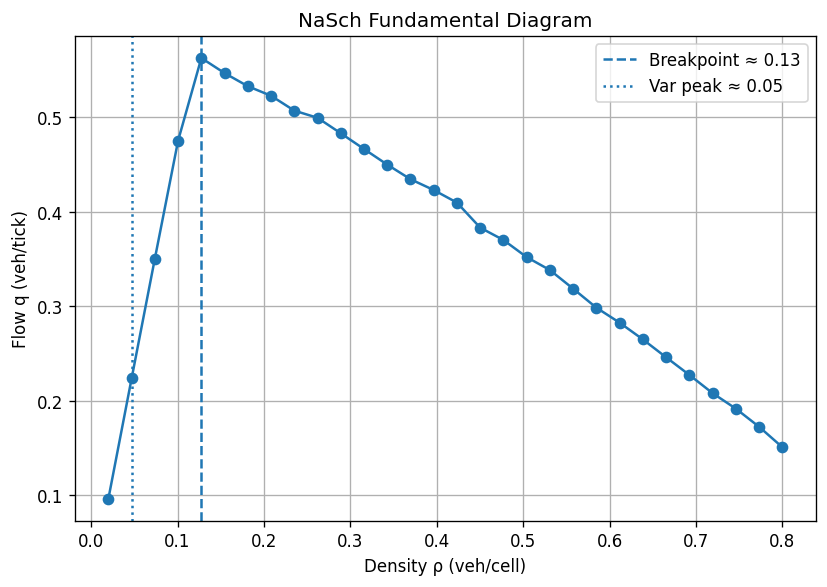

In [7]:
def nasch_ring(L=600, rho=0.15, vmax=5, p=0.2, steps=2000, warm=500, seed=42):
    rng = np.random.default_rng(seed)
    n = int(round(rho*L))
    road = -np.ones(L, dtype=int)
    pos = rng.choice(L, size=n, replace=False)
    road[pos] = rng.integers(0, 6, size=n)
    flows = []
    for t in range(steps):
        # Accel
        road[road>=0] = np.minimum(road[road>=0]+1, vmax)
        # Brake
        occ = np.where(road>=0)[0]
        if len(occ)==0:
            flows.append(0); continue
        next_pos = np.roll(occ, -1)
        gaps = (next_pos - occ - 1) % L
        for i, posi in enumerate(occ):
            road[posi] = min(road[posi], gaps[i])
        # Randomization
        mask = (road>=1) & (rng.random(L)<p); road[mask] -= 1
        # Move
        new = -np.ones(L, dtype=int)
        occ = np.where(road>=0)[0]
        newpos = (occ + road[occ]) % L
        new[newpos] = road[occ]
        passed = ((occ + road[occ]) % L < occ).sum()
        flows.append(passed)
        road = new
    flows = np.array(flows)
    q = flows[warm:].mean(); vbar = q / rho if rho>0 else 0.0
    return q, vbar

def ns_sweep(L=600, vmax=5, p=0.2, steps=2000, warm=500, seeds=5, rhos=None):
    if rhos is None: rhos = np.linspace(0.02,0.8,30)
    q_mean=[]; q_var=[]
    for rho in rhos:
        qs=[]
        for s in range(seeds):
            q,_= nasch_ring(L=L, rho=rho, vmax=vmax, p=p, steps=steps, warm=warm, seed=100+s)
            qs.append(q)
        qs=np.array(qs)
        q_mean.append(qs.mean()); q_var.append(qs.var(ddof=1))
    return rhos, np.array(q_mean), np.array(q_var)

rhos, q_m, q_v = ns_sweep()
bp_ns = estimate_breakpoint(rhos, q_m)
rho_sus, susmax_ns, _ = susceptibility_peak(rhos, q_m)

plt.figure(); plt.plot(rhos, q_m, 'o-');
plt.axvline(bp_ns.x_star, linestyle='--', label=f'Breakpoint ≈ {bp_ns.x_star:.2f}')
plt.axvline(rho_sus, linestyle=':', label=f'Var peak ≈ {rho_sus:.2f}')
plt.xlabel('Density ρ (veh/cell)'); plt.ylabel('Flow q (veh/tick)'); plt.title('NaSch Fundamental Diagram'); plt.legend(); plt.tight_layout(); plt.show()


## 5) Bando / OVM (ring)

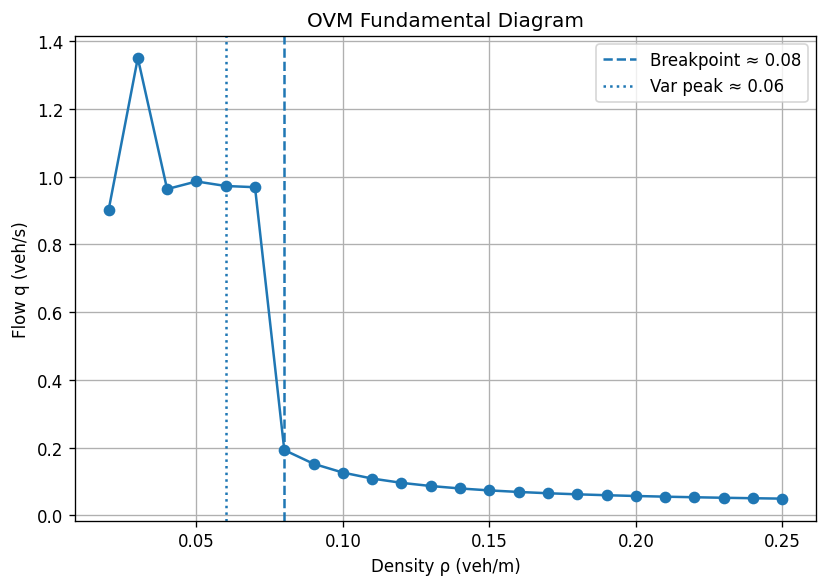

In [8]:
def ovm_ring(L=1000.0, N=100, alpha=1.0, v0=30.0, h0=25.0, delta=8.0, dt=0.2, T=600.0, warm=200.0, seed=1):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, L*(N-1)/N, N)
    v = v0*np.ones(N)
    x += rng.normal(0,0.5,size=N)
    steps=int(T/dt); warm_steps=int(warm/dt)
    def V(h):
        return v0*(np.tanh((h - h0)/delta) + np.tanh(h0/delta))
    flows=[]
    for t in range(steps):
        order=np.argsort(x); x=x[order]; v=v[order]
        h = np.diff(np.r_[x, x[0]+L])
        a = alpha*(V(h) - v)
        v = np.clip(v + a*0.2, 0, v0*1.5)
        x = (x + v*0.2) % L
        if t>=warm_steps: flows.append(v.mean())
    vbar = np.mean(flows) if flows else v.mean(); rho = N/L; q = rho*vbar
    return rho, q, vbar

def ovm_sweep(L=1000.0, Ns=None):
    if Ns is None: Ns = np.arange(20, 260, 10)
    rhos=[]; qs=[]
    for N in Ns:
        rho,q,_ = ovm_ring(L=L, N=N)
        rhos.append(rho); qs.append(q)
    return np.array(rhos), np.array(qs)

rhos_o, q_o = ovm_sweep()
bp_ovm = estimate_breakpoint(rhos_o, q_o)
rho_sus_o, susmax_o, _ = susceptibility_peak(rhos_o, q_o)

plt.figure(); plt.plot(rhos_o, q_o, 'o-');
plt.axvline(bp_ovm.x_star, linestyle='--', label=f'Breakpoint ≈ {bp_ovm.x_star:.2f}')
plt.axvline(rho_sus_o, linestyle=':', label=f'Var peak ≈ {rho_sus_o:.2f}')
plt.xlabel('Density ρ (veh/m)'); plt.ylabel('Flow q (veh/s)'); plt.title('OVM Fundamental Diagram'); plt.legend(); plt.tight_layout(); plt.show()


## 6) Comparison table

In [9]:
rows=[]
if 'bp_obs' in globals() and bp_obs:
    rows.append({'Model':'Observed (proxy)','Critical (x*)':bp_obs.x_star,'Unit':'ρ̂ proxy'})
rows.append({'Model':'Scenario (FD)','Critical (x*)':bp_sim.x_star,'Unit':'Demand D'})
rows.append({'Model':'NaSch (CA)','Critical (x*)':bp_ns.x_star,'Unit':'ρ veh/cell'})
rows.append({'Model':'Bando/OVM','Critical (x*)':bp_ovm.x_star,'Unit':'ρ veh/m'})
crit=pd.DataFrame(rows)
print(crit.to_string(index=False))


           Model  Critical (x*)       Unit
Observed (proxy)       0.206041   ρ̂ proxy
   Scenario (FD)       1.166667   Demand D
      NaSch (CA)       0.127586 ρ veh/cell
       Bando/OVM       0.080000    ρ veh/m


## 7) Analysis guidance

- Compare the **locations** of critical points; explain differences via model parameters.
- Use **variance peaks** as early-warning indicators.
- Calibrate OVM (α, h0, Δ) and NaSch (p, v_max) to align with observed proxy if desired.
- For publishable mapping, regress proxy ρ̂ to measured densities from loop detectors or probe data if available.
